[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Shakiba"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Shakiba"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Shakiba

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Shakiba

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("GOOGLE_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
result

AIMessage(content='The best places to see orcas (killer whales) in the United States are primarily along the Pacific Northwest coast. Here are some top locations:\n\n1. San Juan Islands, Washington\n   - Known as one of the top orca-watching destinations in the world.\n   - Peak viewing season is from May to September.\n   - Many tour operators offer whale-watching trips.\n\n2. Puget Sound, Washington\n   - A prime area for orca sightings, especially around Seattle and Tacoma.\n   - Regular tours depart from Seattle and Edmonds.\n\n3. Vancouver Island, British Columbia (just north of the US border)\n   - Tofino and Victoria are popular spots.\n   - The region is part of the Great Bear Rainforest and offers excellent whale-watching opportunities.\n\n4. Monterey Bay, California\n   - Offers seasonal orca sightings, especially during the summer months.\n   - Several tour operators provide whale-watching excursions.\n\n5. Southern California\n   - Occasionally, orcas are seen off the coast

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 297,
  'prompt_tokens': 71,
  'total_tokens': 368,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4.1-nano-2025-04-14',
 'system_fingerprint': 'fp_17d1f82c3e',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [8]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F9B7D9B810>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001F9B7E2B810>, root_client=<openai.OpenAI object at 0x000001F9B7671450>, root_async_client=<openai.AsyncOpenAI object at 0x000001F9B7D9B9D0>, model_name='gpt-4.1-nano', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy=''), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'type': 'object', 'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b']}}}]})

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Shakiba")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X7lxhFEwVe9lC88XYFOoAWJT', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_17d1f82c3e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6b9ce26d-05fb-4787-a137-d8038ed46cad-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_X7lxhFEwVe9lC88XYFOoAWJT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 17, 'total_tokens': 81})

In [10]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_X7lxhFEwVe9lC88XYFOoAWJT',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

In [11]:
llm_with_tools.invoke([HumanMessage(content="Hello world", name="Shakiba")])

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 58, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_17d1f82c3e', 'finish_reason': 'stop', 'logprobs': None}, id='run-0abe0492-a4b4-4208-aee5-4a4aa5c61609-0', usage_metadata={'input_tokens': 58, 'output_tokens': 10, 'total_tokens': 68})

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Shakiba")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1d2aec94-c1c6-4037-890f-7d71076c22c8'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Shakiba', id='bfe72d97-1763-43b8-aa80-ae7eb9df2c59'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='b51630ab-ea2f-40ed-b784-3ec27f7f7d44')]

## Our graph

Now, lets use `MessagesState` with a graph.

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


In [17]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

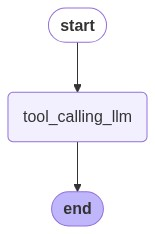

In [18]:
# View
# https://stackoverflow.com/questions/79575640/mermaid-ink-timeout-error-when-using-short-node-name-in-langgraph-diagram
# docker run -p 3000:3000 ghcr.io/jihchi/mermaid.ink
# langchain_core/runnables/graph_mermaid.py/
# http://localhost:3000
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ba0c0yBjjhaZWvDnSW3NqJsv)
 Call ID: call_ba0c0yBjjhaZWvDnSW3NqJsv
  Args:
    a: 2
    b: 3


In [27]:
messages

{'messages': [HumanMessage(content='Multiply 2 and 3', id='99bcc9aa-cfcc-46d5-9dcb-9878fcbb4571'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PPtMnOSVoKsDJd2ydCBladgk', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 58, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50daa3c5-e729-4c1f-a09e-70a4af57a028-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_PPtMnOSVoKsDJd2ydCBladgk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 17, 'total_tokens': 75})]}